In [1]:
import os, sys
sys.path.insert(0, os.path.abspath(".."))

# Chicago cluster

As a second attempt at forming Voroni diagrams:

- Try to "cluster" together the points in the "new" geocoding
- This can be done both by genuine spatial "clusters"
- And also by using the "BLOCK" data as a hint
  - This is a bit vague!
  - Maybe merge points if they belong to the same "block", aren't too far apart, and are on the same line as an existing cluster?
  
  
### Plan

- Can we just use `AggregatePointsViaGraph` at a first pass, or is that too slow?

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.collections
import lzma, pickle, collections
import open_cp.logger
open_cp.logger.log_to_true_stdout("impute")
import open_cp.geometry
open_cp.geometry.configure_gdal()
import impute.chicago
import impute.geometry
import impute.voroni
import numpy as np
import shapely.geometry
import geopandas as gpd
import descartes
import tilemapbase
import pyproj
proj = pyproj.Proj({"init":"epsg:2790"})

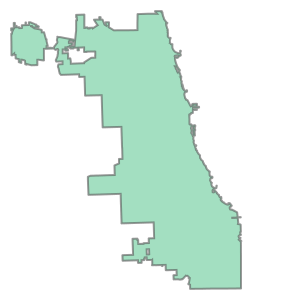

In [3]:
datadir = os.path.join("/media", "disk", "Data")
#datadir = os.path.join("..", "..", "..", "..", "Data")
g = gpd.GeoDataFrame.from_file(os.path.join(datadir, "Chicago_Areas.geojson"))
g.crs = {'init': 'epsg:4326'}
g = g.to_crs({"init":"epsg:2790"}).geometry
chicago = g.unary_union.buffer(15)
chicago

# Load data and form graph

In [25]:
filename = os.path.join(datadir, "chicago_all.csv.xz")

def gen():
    with lzma.open(filename, "rt", encoding="utf8") as f:
        yield from impute.chicago.load_only_with_point(f)
        
next(gen())

Row(id='5189091', crime_type='OFFENSE INVOLVING CHILDREN', crime_subtype='CHILD ABUSE', location='RESIDENCE', address='108XX S AVENUE G', datetime=datetime.datetime(2006, 10, 12, 10, 58), point=(-87.531655723, 41.698387427))

In [5]:
data = [(row.address, row.point) for row in gen()
        if row.datetime.year > 2001]

In [6]:
points = np.asarray([row[1] for row in data])
points = np.asarray(list(proj(*points.T))).T
points.shape

(5840574, 2)

In [10]:
with lzma.open("chicago_raw_points.pic.xz", "wb") as f:
    np.save(f, points)
os.stat("chicago_raw_points.pic.xz").st_size / 1024 / 1024

33.356197357177734

In [7]:
ag = impute.geometry.AggregatePointsViaGraph(points, tolerance=10)

In [8]:
with lzma.open("chicago_merged_raw_points.pic.xz", "wb") as f:
    pickle.dump(ag, f)
os.stat("chicago_merged_raw_points.pic.xz").st_size / 1024 / 1024

10.184185028076172

# Reload and use

In [4]:
with lzma.open("chicago_merged_raw_points.pic.xz", "rb") as f:
    ag = pickle.load(f)

In [5]:
ag.merged_points[:5]

array([[ 359886.00454519,  571107.34056294],
       [ 357966.06552199,  580852.42565839],
       [ 358222.40283067,  560364.94793434],
       [ 366123.1394107 ,  559305.15616138],
       [ 351404.92761135,  588252.37492094]])

In [6]:
ag.merged_points.shape

(78760, 2)

## Try voroni directly

Visualising in QGIS, this doesn't really work, for two reasons:

- Perhaps the freshold of 10 meters was too small.
- We use the _centroid_ of the joined points as the "aggregated point" and then form the Voroni based on this.  This leads to quite a lot of bias
  - Would be better to borrow the idea from `VoroniGraphSegments` and use the graph data more.
  - We _conjecture_ that each merged region should be a line
  - Should pick some points along this line (including start/end points) and use these to form the regions.

In [7]:
voroni = impute.voroni.Voroni(ag.merged_points)

In [8]:
polygons = list(voroni.all_polygons_clipped(chicago))

In [9]:
regions = list(range(len(polygons)))

indices = [i for i,p in enumerate(polygons) if not p.is_empty]
polys = [polygons[i] for i in indices]
regions = [regions[i] for i in indices]

In [10]:
gframe = gpd.GeoDataFrame({"region" : regions})
gframe.geometry = polys
gframe.crs = {"init":"epsg:2790"}
gframe.head()

,region,geometry
0,0,"POLYGON ((344265.750162221 590820.3096482222, ..."
1,1,"POLYGON ((352246.6494384704 567554.1668493678,..."
2,2,"POLYGON ((350824.179430837 563699.2803415859, ..."
3,3,"POLYGON ((350007.2158956578 590246.8691247932,..."
4,4,"POLYGON ((348676.5484669557 586354.2289959956,..."


In [11]:
gframe.to_file("chicago_voroni_from_raw_points_agged")

## Example plots

In [12]:
with lzma.open("chicago_raw_points.pic.xz", "rb") as f:
    points = np.load(f)

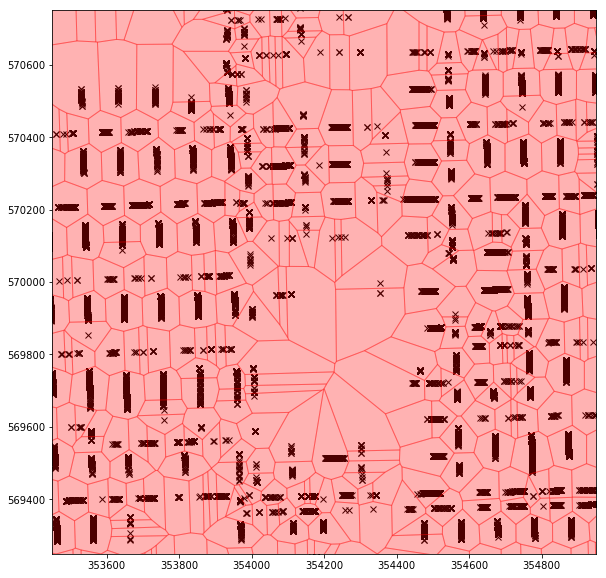

In [13]:
fig, ax = plt.subplots(figsize=(10,10))

for p in polys:
    pp = descartes.PolygonPatch(p, color="red", alpha=0.3)
    ax.add_patch(pp)

ax.scatter(*points.T, marker="x", linewidth=1, color="black")
x, y = 354200, 570000
d = 750
ax.set(xlim=[x-d,x+d], ylim=[y-d,y+d])
ax.set_aspect(1)

In [14]:
fig.savefig("chicago_cluster_one.png")

# Look at the pattern of points by "block"

- Look at each group of merged points
- Do they form a (straight) line?

**Answer:**
- No, but mostly they do.  There are some cases of intersecting lines, or curves.

In [4]:
with lzma.open("chicago_merged_raw_points.pic.xz", "rb") as f:
    ag = pickle.load(f)
with lzma.open("chicago_raw_points.pic.xz", "rb") as f:
    points = np.load(f)

In [13]:
agged_points_to_points = collections.defaultdict(set)

for pt in points:
    agged_points_to_points[ag.index(pt)].add(tuple(pt))
    
agged_points_to_points = { k : np.asarray(list(d)) for k,d in agged_points_to_points.items() }

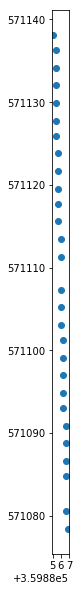

In [17]:
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(*agged_points_to_points[0].T)
ax.set_aspect(1)

In [40]:
def optimal_rotate(points):
    points = np.asarray(points)
    assert len(points.shape) == 2 and points.shape[1] == 2
    points = points - np.mean(points, axis=0)
    alpha = np.sum(points[:,0]**2)
    beta = np.sum(points[:,1]**2)
    gamma = np.sum(points[:,0] * points[:,1])
    phi = np.arctan2((beta - alpha)/2, -gamma)
    c = np.sqrt( ((beta-alpha)/2)**2 + gamma**2 )
    avg_d = ((alpha + beta) / 2 - c) / points.shape[0]
    return 3 * np.pi / 4 - phi / 2, avg_d

t, d = optimal_rotate(agged_points_to_points[0])
t, d

(1.5977545580284578, 0.0086033010415706348)

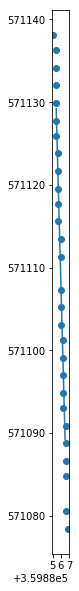

In [35]:
xcs = agged_points_to_points[0][:,0]
ycs = agged_points_to_points[0][:,1]
x, y = np.mean(xcs, axis=0), np.mean(ycs, axis=0)

fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(*agged_points_to_points[0].T)
ax.set_aspect(1)

d = 20
x1, y1 = x - d * np.cos(t), y - d * np.sin(t)
x2, y2 = x + d * np.cos(t), y + d * np.sin(t)

ax.plot([x1,x2], [y1,y2])

In [49]:
avg_dist = {i : optimal_rotate(pts)[1] for i, pts in agged_points_to_points.items()}
avg_dist = list(avg_dist.items())
avg_dist.sort(key = lambda p : p[1])

In [56]:
avg_dist[-10:]

[(16946, 26.882356781577013),
 (6715, 28.560414679404577),
 (19266, 29.047854202581092),
 (3759, 29.360578351504127),
 (5898, 30.515463525095317),
 (42754, 35.144339189163865),
 (1623, 41.194854654266408),
 (8928, 42.247559755903985),
 (1052, 77.865009927742818),
 (31387, 83.716192316255857)]

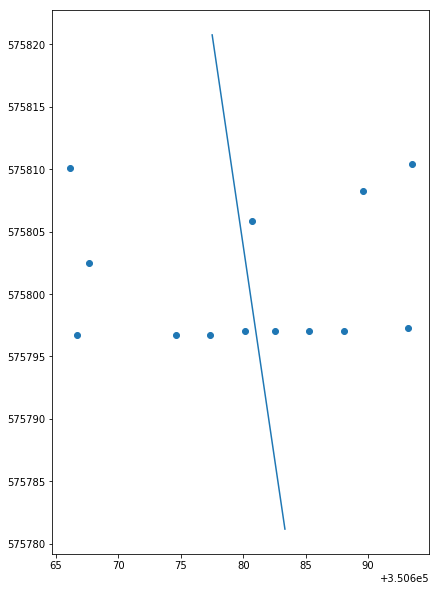

In [62]:
i = 3759
xcs = agged_points_to_points[i][:,0]
ycs = agged_points_to_points[i][:,1]
x, y = np.mean(xcs, axis=0), np.mean(ycs, axis=0)

fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(*agged_points_to_points[i].T)
ax.set_aspect(1)

d = 20
x1, y1 = x - d * np.cos(t), y - d * np.sin(t)
x2, y2 = x + d * np.cos(t), y + d * np.sin(t)

ax.plot([x1,x2], [y1,y2])

# Just merge the cells

Why don't I just use the points, and then merge Voroni cells?

I found that the very close spacing of points along lines caused numerical instability issues.  A way around this is to add some "artifical" points around the edge of the data (we use a dilated version of the geometry we'll clip to).

In [15]:
with lzma.open("chicago_merged_raw_points.pic.xz", "rb") as f:
    ag = pickle.load(f)
with lzma.open("chicago_raw_points.pic.xz", "rb") as f:
    points = np.load(f)

In [16]:
points.shape

(5840574, 2)

In [17]:
uniques_points_counts = collections.defaultdict(int)
for x,y in points:
    uniques_points_counts[(x,y)] += 1
unique_points = np.asarray(list(uniques_points_counts))
unique_points.shape

(629625, 2)

In [18]:
sections = collections.defaultdict(set)

for i, pt in enumerate(unique_points):
    sections[ ag.index(pt) ].add(i)
    
sections = list(sections.values())

In [19]:
# Add circle around
circle = np.asarray(list(chicago.buffer(10000).exterior.coords))
sections.append({unique_points.shape[0]+i for i in range(circle.shape[0])})
unique_points = np.vstack([unique_points, circle])

In [20]:
voroni = impute.voroni.VoroniMergedCells(unique_points, sections)

In [21]:
polygons = list(voroni.all_polygons_clipped(chicago.buffer(10)))

### Save to shapefile

In [13]:
gframe = gpd.GeoDataFrame({
    "polygon" : [i for i,p in enumerate(polygons) if not p.is_empty]
    })
gframe.geometry = [p for p in polygons if not p.is_empty]
gframe.crs = {"init":"epsg:2790"}
gframe.to_file("chicago_voroni_merged_agged_raw_points")

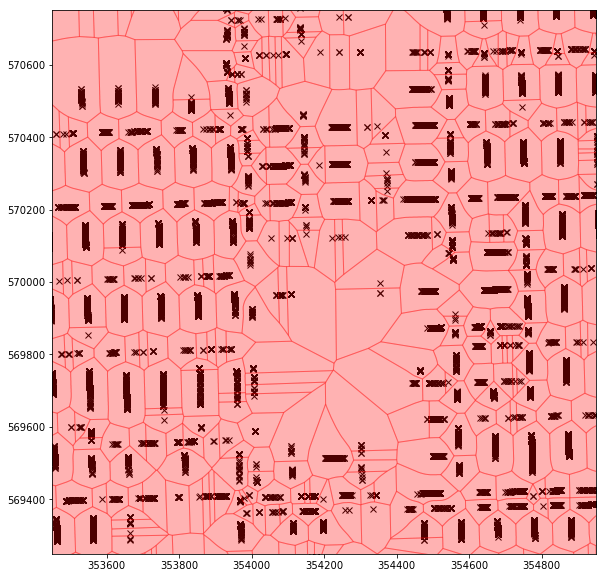

In [22]:
fig, ax = plt.subplots(figsize=(10,10))

for p in polygons:
    if p.is_empty:
        continue
    pp = descartes.PolygonPatch(p, color="red", alpha=0.3)
    ax.add_patch(pp)

ax.scatter(*points.T, marker="x", linewidth=1, color="black")
x, y = 354200, 570000
d = 750
ax.set(xlim=[x-d,x+d], ylim=[y-d,y+d])
ax.set_aspect(1)

In [23]:
fig.savefig("chicago_cluster_two.png")

## Thoughts

This seem to work pretty well.
- We do end up with some pretty small cells.
- Actually, we end up with something which is really close to our first attempt.  Difference is that we expand cells with a large "cluster" in.

Let's try merging further.  Look at cells:
- Which touch each other
- Are small
- Contain a small number of points (this should be "total crime events" not "unique point count").
- Have some overlap in assigned "BLOCK"

In [27]:
def gen1():
    for row in gen():
        if row.datetime.year > 2001:
            yield row

# Make a lookup from the point to the "block" name
blocks = collections.defaultdict(set)
for pt, row in zip(points, gen1()):
    np.testing.assert_allclose(pt, proj(*row.point))
    blocks[tuple(pt)].add(row.address)

In [54]:
def points_in_polygon(poly, points):
    xmin, ymin, xmax, ymax = poly.bounds
    pts = points[np.all((points >= [xmin, ymin]) & (points <= [xmax, ymax]), axis=1), :]
    pts = shapely.geometry.MultiPoint(pts).intersection(poly)
    pts = np.asarray(pts)
    if len(pts.shape) == 1:
        pts = pts[None,:]
    return pts

def blocks_for_polygon(poly, points, blocks):
    """Return a set of the block names for which there is a point in the polygon."""
    pts = points_in_polygon(poly, points)
    out = set()
    for pt in pts:
        out.update(blocks[tuple(pt)])
    return out

blocks_for_polygon(polygons[2], points, blocks)

{'014XX E 74TH ST'}

In [55]:
def count_points_in_polygon(poly, points):
    return points_in_polygon(poly, points).shape[0]

polygons[0].area

14445.113356526459

Collect a list of the polygons which are:
- small (at most $100^2$ meters square)
- contain few points (at most 30)

In [30]:
mergeable_polygons = []
for poly in polygons:
    if poly.is_empty:
        mergeable_polygons.append(False)
        continue
    count = count_points_in_polygon(poly, points)
    area = poly.area
    if count < 30 and area < 100*100:
        mergeable_polygons.append(True)
    else:
        mergeable_polygons.append(False)

In [32]:
mergeable_polygon_indices = [i for i, want in enumerate(mergeable_polygons) if want]

We'll merge the polygons by constructing a graph, whose nodes are the polygons, and where we link polygons which can be merged.  Then we'll find the connected components.

Polygons can be merged if they touch, and there is some overlap in the containing block.

In [36]:
import open_cp.logger, logging, datetime
open_cp.logger.log_to_true_stdout("cluster")
logger = logging.getLogger("cluster")

In [56]:
blocks_from_polygons = []
for i in mergeable_polygon_indices:
    p = polygons[i]
    b = blocks_for_polygon(p, points, blocks)
    blocks_from_polygons.append(b)

In [59]:
total_task = len(mergeable_polygon_indices) * (len(mergeable_polygon_indices)-1) // 2
pl = open_cp.logger.ProgressLogger(total_task, datetime.timedelta(seconds=15), logger)
builder = open_cp.network.GraphBuilder()
for idx, i in enumerate(mergeable_polygon_indices):
    p1 = polygons[i]
    b1 = blocks_from_polygons[idx]
    for idx1 in range(idx+1, len(mergeable_polygon_indices)):
        j = mergeable_polygon_indices[idx1]
        p2 = polygons[j]
        b2 = blocks_from_polygons[idx1]
        if len(b1 & b2) > 0 and p1.intersects(p2):
            builder.add_edge(i, j)
    pl.add_to_count(len(mergeable_polygon_indices)-idx)

In [60]:
graph = builder.build()

### Assemble all polygons

In [89]:
final_merged_polygons = []
used_indicies = set()
for c in open_cp.network.connected_components(graph):
    c = list(c)
    p = polygons[c[0]]
    for i in c[1:]:
        pp = polygons[i]
        p = p.union(pp)
    used_indicies.update(c)
    final_merged_polygons.append(p)

In [90]:
for i, p in enumerate(polygons):
    if i not in used_indicies:
        final_merged_polygons.append(p)

In [100]:
final_merged_polygons = [p for p in final_merged_polygons if not p.is_empty]

In [101]:
frame = gpd.GeoDataFrame({"i" : list(range(len(final_merged_polygons)))})
frame.geometry = final_merged_polygons
frame.crs = {"init":"epsg:2790"}
frame.to_file("chicago_clustered_merged_polygons")

# Some plots

In [102]:
def project_polygon(p):
    if p.geometryType() == "Polygon":
        poly = []
        for x, y in zip(*proj(*np.asarray(p.exterior).T, inverse=True)):
            poly.append(tilemapbase.project(x, y))
        return shapely.geometry.Polygon(poly)
    else:
        return shapely.geometry.MultiPolygon([project_polygon(pp) for pp in p])

In [103]:
def make_lines():
    lines = []
    for i, seg in enumerate(segments):
        line = [graph.vertices[key] for key in open_cp.network.edge_segment_to_vertices(graph, seg)]
        linex, liney = proj(*np.asarray(line).T, inverse=True)
        line = [tilemapbase.project(x,y) for x,y in zip(linex, liney)]
        lines.append(line)
    return lines

def draw(lon, lat, xsize=0.0001, voroni_points = False):
    ex = tilemapbase.Extent.from_centre_lonlat(lon, lat, xsize)
    plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=800)

    fig, ax = plt.subplots(figsize=(8,8))
    plotter.plot(ax, alpha=0.6)

    #lc = matplotlib.collections.LineCollection(make_lines())
    #ax.add_collection(lc)

    pp = [descartes.PolygonPatch(project_polygon(p)) for p in final_merged_polygons]
    pp = matplotlib.collections.PatchCollection(pp, color="red", alpha=0.3)
    ax.add_collection(pp)
    
    #if voroni_points:
    #    points = [tilemapbase.project(x, y) for x, y in zip(*proj(*voroni._voroni.points.T, inverse=True))]
    #    ax.scatter(*np.asarray(points).T, marker="x", color="black", linewidth=0.5)

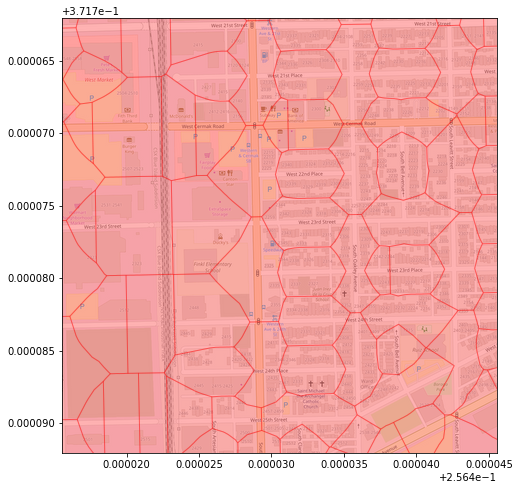

In [104]:
draw(-87.685, 41.85, 0.00003, True)